In [149]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Loading Dataset

In [150]:
# Ambil data saham BBCA dari Yahoo Finance
df = yf.download("BBCA.JK", start="2018-01-01", end="2025-5-29")

# Lihat 5 baris pertama
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK
Date,,,,,
2018-01-01,3723.926270,3723.926270,3723.926270,3723.926270,0
2018-01-02,3723.926270,3830.202704,3711.173097,3723.926270,82303500
2018-01-03,3723.926270,3732.428384,3626.151950,3728.177327,68214000
2018-01-04,3779.190674,3779.190674,3723.926918,3723.926918,76567000
2018-01-05,3783.440430,3808.946770,3770.687260,3791.942543,65268000


In [151]:
# Statistik deskriptif
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK,BBCA.JK
count,1821.000000,1821.000000,1821.000000,1821.000000,1.821000e+03
mean,6591.288806,6650.912798,6532.491053,6592.331373,8.326811e+07
std,1898.744225,1911.897252,1887.138039,1898.273909,5.535698e+07
min,3529.552246,3606.654247,3529.552246,3589.520711,0.000000e+00
25%,5067.398926,5117.358527,5014.291437,5062.974230,5.416800e+07
50%,6059.347656,6170.324219,6028.274263,6103.738924,7.255150e+07
75%,8343.284180,8428.511158,8300.000000,8358.078266,9.824950e+07
max,10570.414062,10570.414456,10401.480891,10522.147296,7.564316e+08


In [152]:
print(df)

Price             Close         High          Low         Open     Volume
Ticker          BBCA.JK      BBCA.JK      BBCA.JK      BBCA.JK    BBCA.JK
Date                                                                     
2018-01-01  3723.926270  3723.926270  3723.926270  3723.926270          0
2018-01-02  3723.926270  3830.202704  3711.173097  3723.926270   82303500
2018-01-03  3723.926270  3732.428384  3626.151950  3728.177327   68214000
2018-01-04  3779.190674  3779.190674  3723.926918  3723.926918   76567000
2018-01-05  3783.440430  3808.946770  3770.687260  3791.942543   65268000
...                 ...          ...          ...          ...        ...
2025-05-22  9650.000000  9800.000000  9650.000000  9800.000000  103113000
2025-05-23  9675.000000  9700.000000  9625.000000  9675.000000   48521800
2025-05-26  9625.000000  9650.000000  9500.000000  9600.000000   56625300
2025-05-27  9450.000000  9600.000000  9450.000000  9550.000000   93212000
2025-05-28  9400.000000  9550.000000  

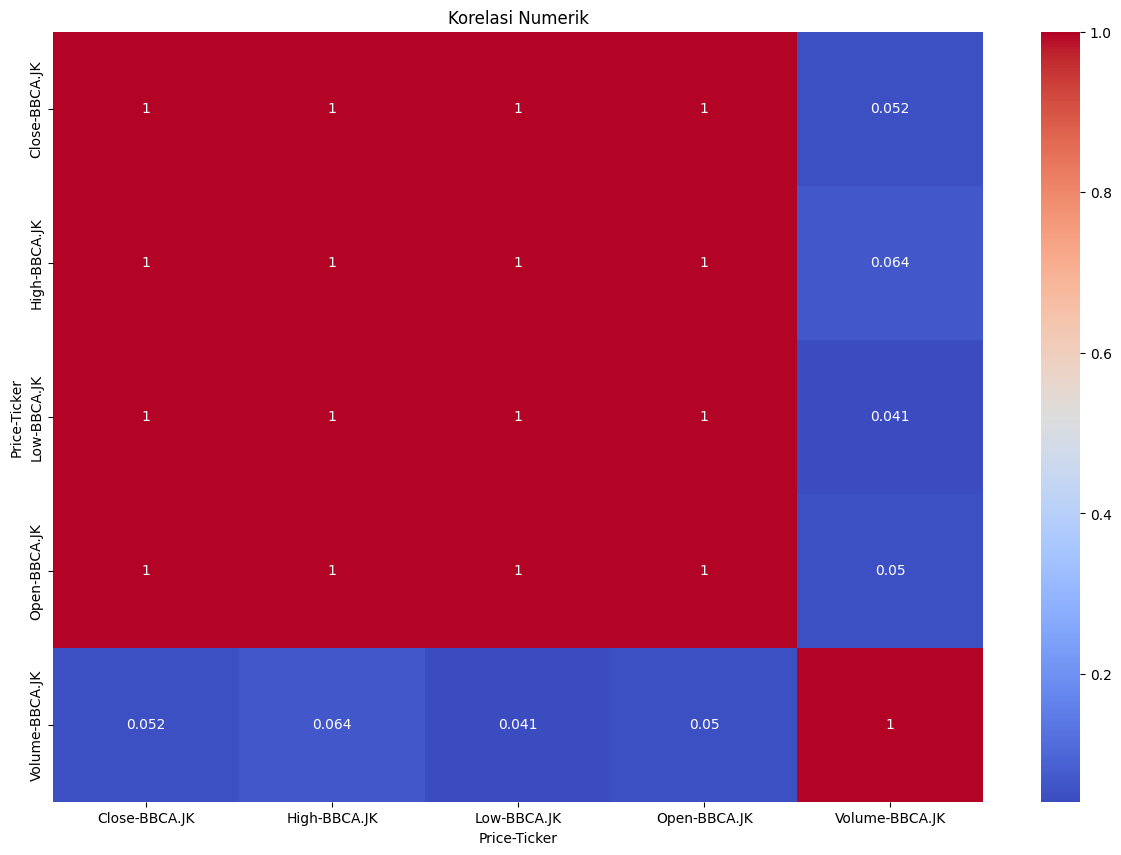

In [153]:
numerical_columns = df.select_dtypes(include=np.number)
plt.figure(figsize=(15, 10))
sns.heatmap(numerical_columns.corr(), annot=True, cmap='coolwarm')
plt.title('Korelasi Numerik')
plt.show()

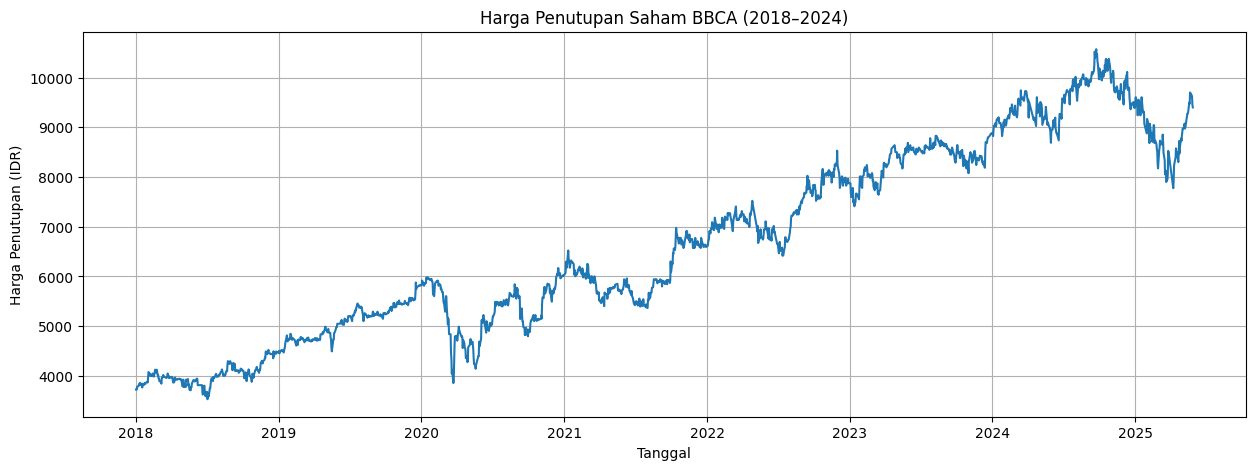

In [154]:
plt.figure(figsize=(15,5))
plt.plot(df['Close'])
plt.title('Harga Penutupan Saham BBCA (2018–2024)')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan (IDR)')
plt.grid(True)
plt.show()

# Pembersihan dan Pra Pemrosesan Data

In [155]:
# pengecekan dataset menggunakan isnull().sum()
df_clear = df.isnull().sum()
print(df_clear)

Price   Ticker 
Close   BBCA.JK    0
High    BBCA.JK    0
Low     BBCA.JK    0
Open    BBCA.JK    0
Volume  BBCA.JK    0
dtype: int64


In [156]:
# pengecekan duplikat
df_clear = df.duplicated().sum()
print(df_clear)

19


In [157]:
# Menghilangkan duplikat
df.drop_duplicates(inplace=True)

In [158]:
# pemilihan fitur
# Tambahkan fitur teknikal
df['MA7'] = df['Close'].rolling(window=7).mean()
df['MA14'] = df['Close'].rolling(window=14).mean()
df['Return'] = df['Close'].pct_change()
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

features = df[['Open', 'High', 'Low', 'Close', 'Volume', 'MA7', 'MA14', 'Return']]
target = df['target']

# Drop rows with NaN values that were introduced by feature engineering
# This ensures that the scaler and the models receive clean data.
df.dropna(inplace=True)

# Re-assign features and target from the DataFrame after dropping NaNs
features = df[['Open', 'High', 'Low', 'Close', 'Volume', 'MA7', 'MA14', 'Return']]
target = df['target']

In [159]:
# Inisialisasi StandardScaler
scaler = StandardScaler()

# Melakukan scaling pada kolom numerik
features = scaler.fit_transform(features)

# Menampilkan DataFrame setelah scaling
print(features)

[[-1.51531204 -1.50498838 -1.49124299 ... -1.49046688 -1.50135748
   1.19591888]
 [-1.48145448 -1.50050468 -1.47762552 ... -1.49046688 -1.49780209
  -0.39751261]
 [-1.48822617 -1.50723046 -1.4753561  ... -1.49337242 -1.49408511
   0.03110418]
 ...
 [ 1.57309177  1.55745839  1.56075724 ...  1.55972959  1.44107047
  -0.373721  ]
 [ 1.5465434   1.53109001  1.53406285 ...  1.57112095  1.45912812
  -1.21243344]
 [ 1.49344665  1.50472163  1.50736847 ...  1.56352671  1.47338415
  -0.38165107]]


# Membangun model

In [160]:
X_train, X_valid, Y_train, Y_valid = train_test_split(features, target, test_size=0.2, random_state=42, shuffle=False)
print(X_train.shape, X_valid.shape)

(1431, 8) (358, 8)


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.95      0.70       197
           1       0.57      0.07      0.13       161

    accuracy                           0.56       358
   macro avg       0.56      0.51      0.42       358
weighted avg       0.56      0.56      0.45       358



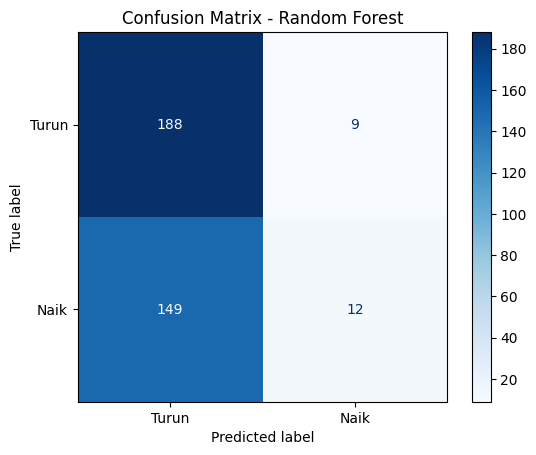

Random Forest Accuracy: 0.5586592178770949
Random Forest Precision: 0.5714285714285714
Random Forest Recall: 0.07453416149068323


In [161]:
# Model Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, Y_train)

# Prediksi dengan Random Forest
predictions_rf = model_rf.predict(X_valid)

# Evaluasi model Random Forest
print("Random Forest Classification Report:")
print(classification_report(Y_valid, predictions_rf))

cm_rf = confusion_matrix(Y_valid, predictions_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Turun', 'Naik'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest')
plt.show()

print("Random Forest Accuracy:", accuracy_score(Y_valid, predictions_rf))
print("Random Forest Precision:", precision_score(Y_valid, predictions_rf))
print("Random Forest Recall:", recall_score(Y_valid, predictions_rf))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.85      0.68       197
           1       0.54      0.21      0.30       161

    accuracy                           0.56       358
   macro avg       0.55      0.53      0.49       358
weighted avg       0.56      0.56      0.51       358



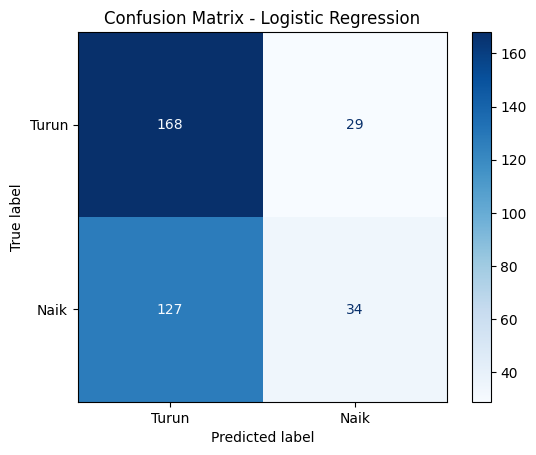

Logistic Regression Accuracy: 0.5642458100558659
Logistic Regression Precision: 0.5396825396825397
Logistic Regression Recall: 0.2111801242236025


In [162]:
# Model Logistic Regression
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, Y_train)

# Prediksi dengan Logistic Regression
predictions_lr = model_lr.predict(X_valid)

# Evaluasi model Logistic Regression
print("Logistic Regression Classification Report:")
print(classification_report(Y_valid, predictions_lr))

cm_lr = confusion_matrix(Y_valid, predictions_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['Turun', 'Naik'])
disp_lr.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

print("Logistic Regression Accuracy:", accuracy_score(Y_valid, predictions_lr))
print("Logistic Regression Precision:", precision_score(Y_valid, predictions_lr))
print("Logistic Regression Recall:", recall_score(Y_valid, predictions_lr))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:24:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.92      0.69       197
           1       0.52      0.10      0.17       161

    accuracy                           0.55       358
   macro avg       0.54      0.51      0.43       358
weighted avg       0.54      0.55      0.46       358



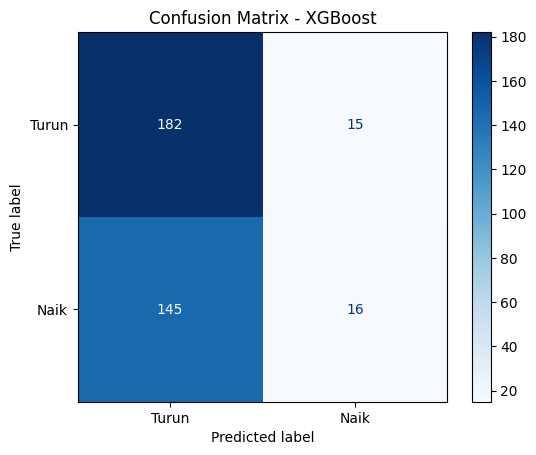

XGBoost Accuracy: 0.553072625698324
XGBoost Precision: 0.5161290322580645
XGBoost Recall: 0.09937888198757763


In [163]:
# Model XGBoost
model_xgb = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb.fit(X_train, Y_train)

# Prediksi dengan XGBoost
predictions_xgb = model_xgb.predict(X_valid)

# Evaluasi model XGBoost
print("XGBoost Classification Report:")
print(classification_report(Y_valid, predictions_xgb))

cm_xgb = confusion_matrix(Y_valid, predictions_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['Turun', 'Naik'])
disp_xgb.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - XGBoost')
plt.show()

print("XGBoost Accuracy:", accuracy_score(Y_valid, predictions_xgb))
print("XGBoost Precision:", precision_score(Y_valid, predictions_xgb))
print("XGBoost Recall:", recall_score(Y_valid, predictions_xgb))


#hasil Gambar Prediksi setiap klasifikasi

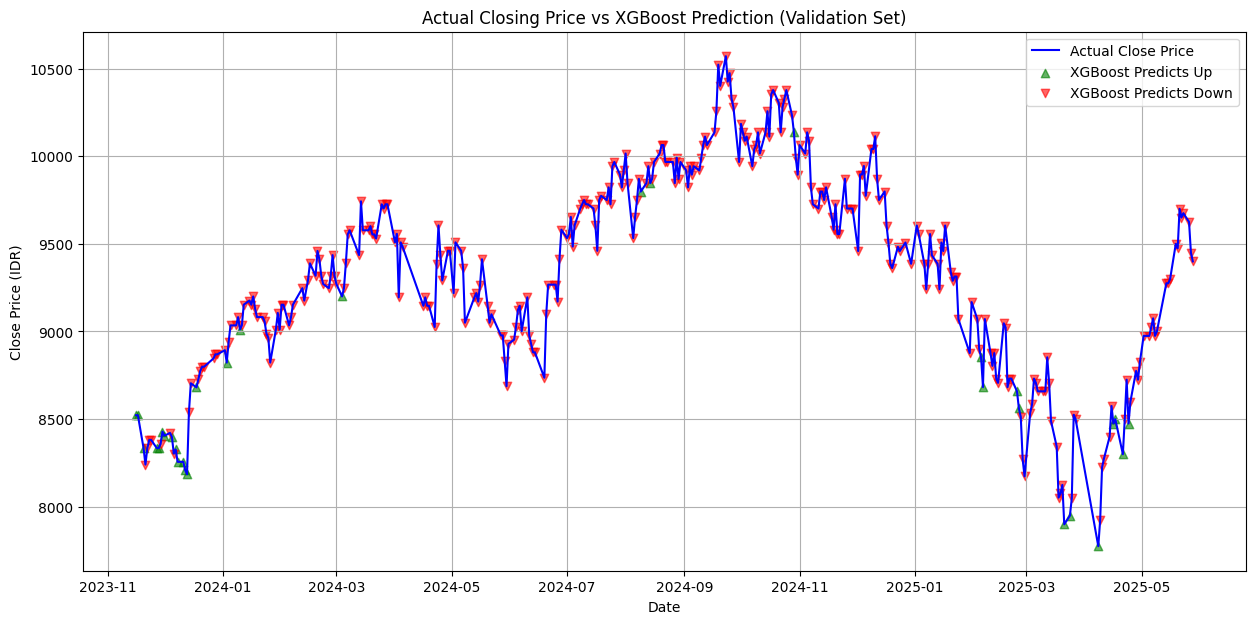

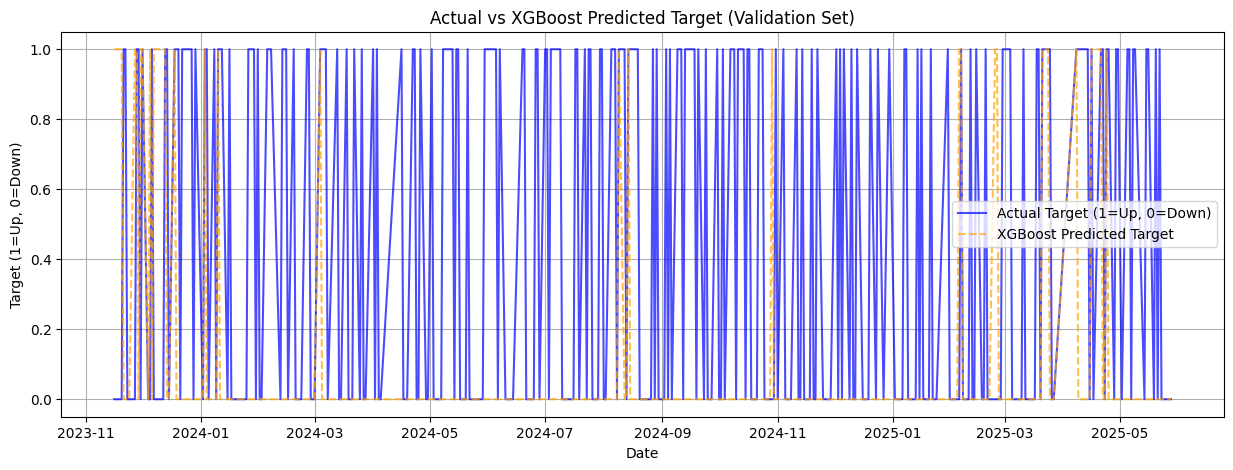

In [164]:
# Combine original data with predictions for visualization
df_valid = df.iloc[X_train.shape[0]:].copy() # Get the validation set from the original df
df_valid['Actual'] = Y_valid

# Make predictions using the trained model and assign them to the column
# The original code assigned the model object itself, causing the error.
df_valid['XGBoost_Predicted'] = model_xgb.predict(X_valid)

# Plot actual closing prices vs XGBoost predicted movement
plt.figure(figsize=(15, 7))

# Plot the actual closing price
plt.plot(df_valid.index, df_valid['Close'], label='Actual Close Price', color='blue')

# Highlight points where XGBoost predicts the price will go up (1) or down (0)
# We can color-code the actual close price points based on the prediction
up_preds = df_valid[df_valid['XGBoost_Predicted'] == 1]
down_preds = df_valid[df_valid['XGBoost_Predicted'] == 0]

plt.scatter(up_preds.index, up_preds['Close'], color='green', marker='^', alpha=0.6, label='XGBoost Predicts Up')
plt.scatter(down_preds.index, down_preds['Close'], color='red', marker='v', alpha=0.6, label='XGBoost Predicts Down')

plt.title('Actual Closing Price vs XGBoost Prediction (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Close Price (IDR)')
plt.legend()
plt.grid(True)
plt.show()

# You can also plot the actual target vs predicted target directly on the validation set
plt.figure(figsize=(15, 5))
plt.plot(df_valid.index, df_valid['Actual'], label='Actual Target (1=Up, 0=Down)', color='blue', alpha=0.7)
plt.plot(df_valid.index, df_valid['XGBoost_Predicted'], label='XGBoost Predicted Target', color='orange', linestyle='--', alpha=0.7)
plt.title('Actual vs XGBoost Predicted Target (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Target (1=Up, 0=Down)')
plt.legend()
plt.grid(True)
plt.show()

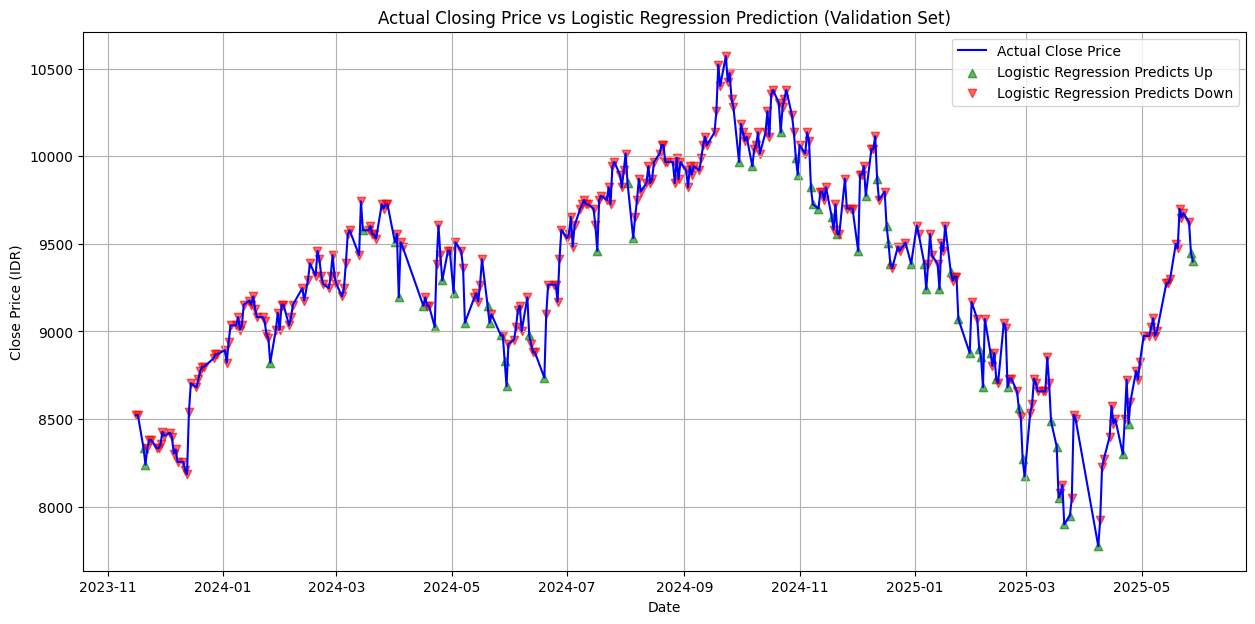

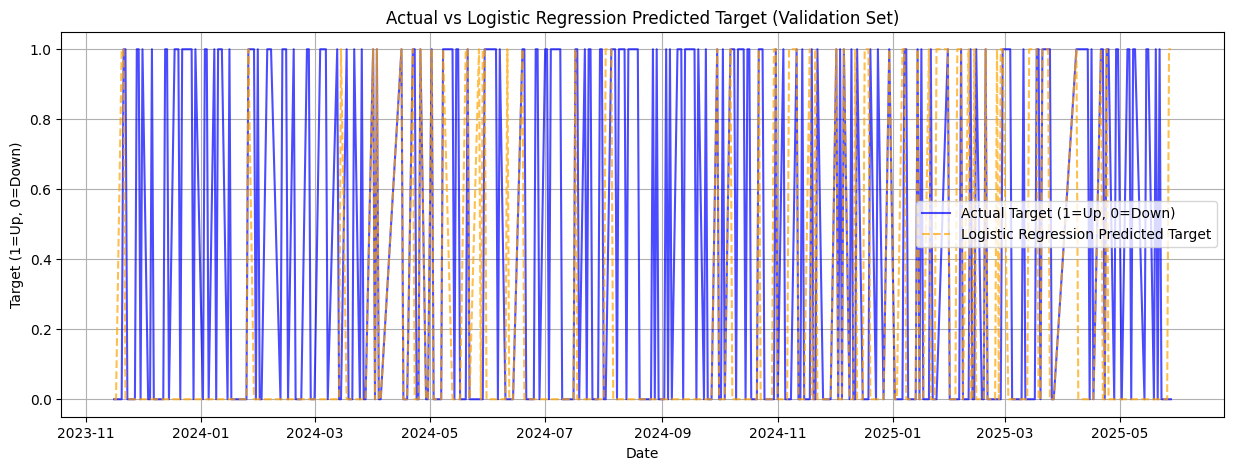

In [165]:
# Combine original data with predictions for visualization
df_valid = df.iloc[X_train.shape[0]:].copy() # Get the validation set from the original df
df_valid['Actual'] = Y_valid

# Make predictions using the trained model and assign them to the column
df_valid['LogisticRegression_Predicted'] = model_lr.predict(X_valid)

# Plot actual closing prices vs Logistic Regression predicted movement
plt.figure(figsize=(15, 7))

# Plot the actual closing price
plt.plot(df_valid.index, df_valid['Close'], label='Actual Close Price', color='blue')

# Highlight points where Logistic Regression predicts the price will go up (1) or down (0)
up_preds_lr = df_valid[df_valid['LogisticRegression_Predicted'] == 1]
down_preds_lr = df_valid[df_valid['LogisticRegression_Predicted'] == 0]

plt.scatter(up_preds_lr.index, up_preds_lr['Close'], color='green', marker='^', alpha=0.6, label='Logistic Regression Predicts Up')
plt.scatter(down_preds_lr.index, down_preds_lr['Close'], color='red', marker='v', alpha=0.6, label='Logistic Regression Predicts Down')

plt.title('Actual Closing Price vs Logistic Regression Prediction (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Close Price (IDR)')
plt.legend()
plt.grid(True)
plt.show()

# You can also plot the actual target vs predicted target directly on the validation set
plt.figure(figsize=(15, 5))
plt.plot(df_valid.index, df_valid['Actual'], label='Actual Target (1=Up, 0=Down)', color='blue', alpha=0.7)
plt.plot(df_valid.index, df_valid['LogisticRegression_Predicted'], label='Logistic Regression Predicted Target', color='orange', linestyle='--', alpha=0.7)
plt.title('Actual vs Logistic Regression Predicted Target (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Target (1=Up, 0=Down)')
plt.legend()
plt.grid(True)
plt.show()


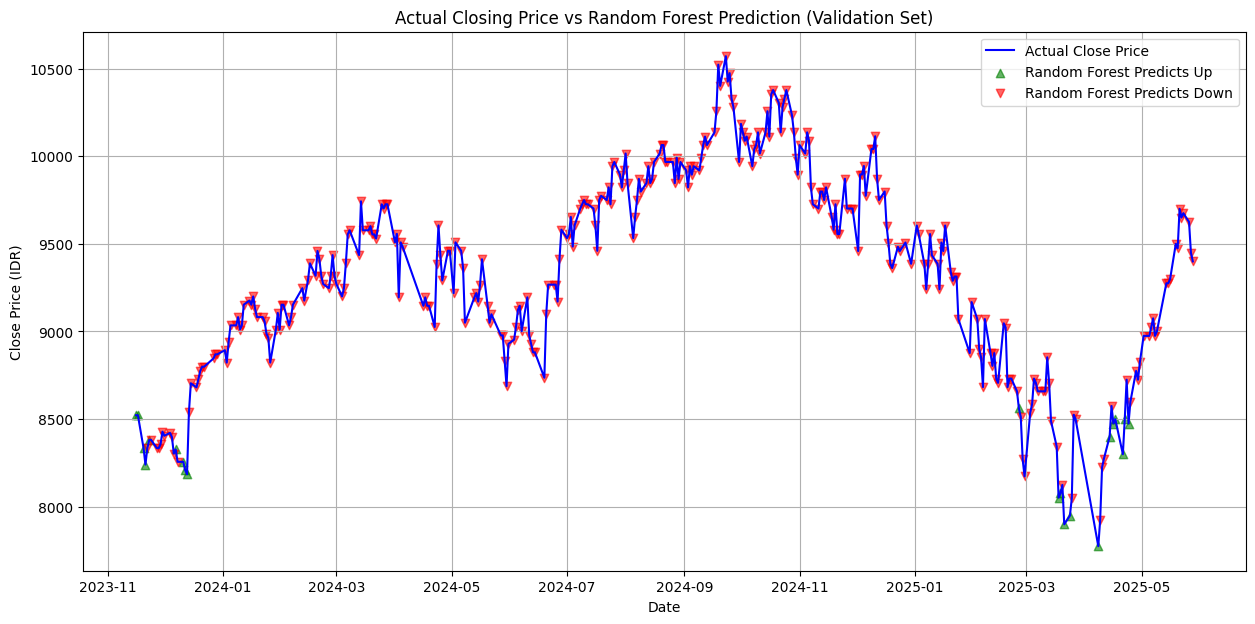

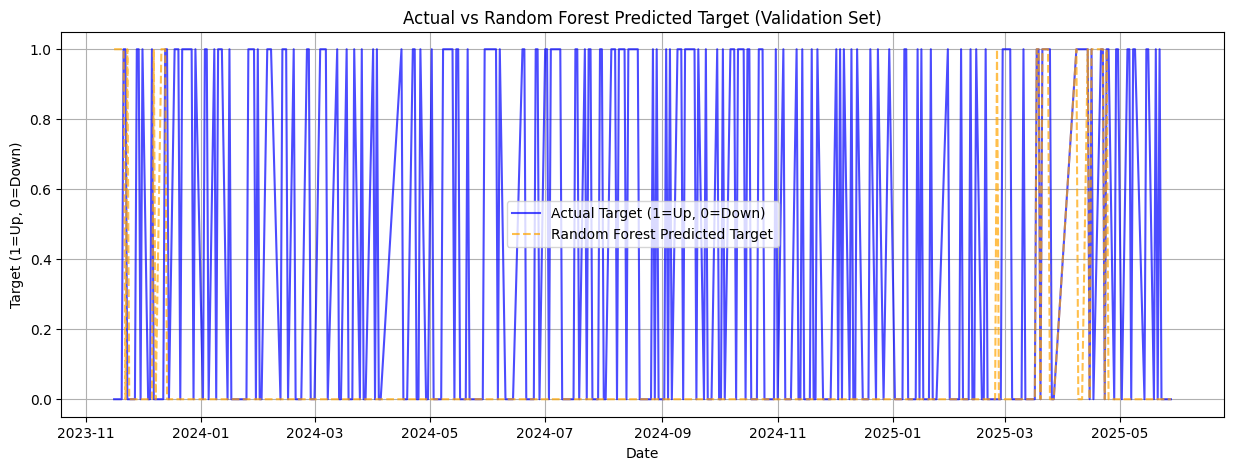

In [166]:
# Combine original data with predictions for visualization
df_valid = df.iloc[X_train.shape[0]:].copy() # Get the validation set from the original df
df_valid['Actual'] = Y_valid

# Make predictions using the trained model and assign them to the column
df_valid['RandomForest_Predicted'] = model_rf.predict(X_valid)

# Plot actual closing prices vs Random Forest predicted movement
plt.figure(figsize=(15, 7))

# Plot the actual closing price
plt.plot(df_valid.index, df_valid['Close'], label='Actual Close Price', color='blue')

# Highlight points where Random Forest predicts the price will go up (1) or down (0)
up_preds_rf = df_valid[df_valid['RandomForest_Predicted'] == 1]
down_preds_rf = df_valid[df_valid['RandomForest_Predicted'] == 0]

plt.scatter(up_preds_rf.index, up_preds_rf['Close'], color='green', marker='^', alpha=0.6, label='Random Forest Predicts Up')
plt.scatter(down_preds_rf.index, down_preds_rf['Close'], color='red', marker='v', alpha=0.6, label='Random Forest Predicts Down')

plt.title('Actual Closing Price vs Random Forest Prediction (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Close Price (IDR)')
plt.legend()
plt.grid(True)
plt.show()

# You can also plot the actual target vs predicted target directly on the validation set
plt.figure(figsize=(15, 5))
plt.plot(df_valid.index, df_valid['Actual'], label='Actual Target (1=Up, 0=Down)', color='blue', alpha=0.7)
plt.plot(df_valid.index, df_valid['RandomForest_Predicted'], label='Random Forest Predicted Target', color='orange', linestyle='--', alpha=0.7)
plt.title('Actual vs Random Forest Predicted Target (Validation Set)')
plt.xlabel('Date')
plt.ylabel('Target (1=Up, 0=Down)')
plt.legend()
plt.grid(True)
plt.show()